### 중요!! AI Class 기본 메서드 : \__init__, \__len__, \__getitem__

\__init__ : 클래스를 생성할 때 실행되는 생성자<br>
\__len__ : 원소의 개수를 셀 때 접근되는 메서드<br>
\__getitem__ : 인덱스에 접근할 때 호출되는 메소드

[EX]
~~~python
class Test:
    def __init__(self) :
        print("TEST 함수 실행")
        self.numbers = [i for i in range(10)]
    def __len__(self) :
        return len(self.numbers)
    def __getitem__(self, idx) :
        return self.numbers[idx]
~~~

T = Test() : TEST 함수 실행<br>
len(T) : 10<br>
T[3] : 3

In [1]:
class Test:
    def __init__(self) :
        print("TEST 함수 실행")
        self.numbers = [i for i in range(10)]
        self.array = [1,2,3,4]
    def __len__(self) :
        return len(self.numbers)
    def __getitem__(self, idx) :
        print(f"전체 길이 : {len(self)}")
        return self.numbers[idx], self.array

In [2]:
T = Test()
T[3]

TEST 함수 실행
전체 길이 : 10


(3, [1, 2, 3, 4])

In [1]:
# import libraries

import torchvision
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms.functional import to_tensor, to_pil_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import tensorflow as tf
import cv2 as cv
import random
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET # 이걸 이용해 파싱

2025-04-10 19:34:00.547154: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 19:34:00.614509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744281240.664485  356134 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744281240.679822  356134 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744281240.804121  356134 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744281240.804135  356134 computation_placer.cc:177] computation placer already registered. Please che

In [2]:
class CustomVOCDataset(Dataset):
    def __init__(self, root, image_set=None, transform=None) :
        self.root = root #PascalVOC 메인폴더의 경로
        # Main폴더의 4개 텍스트 파일로 설정할 모드(test, train, val, trainval)
        self.image_set = image_set 
        self.transform = transform

        # 경로 변수
        self.voc_root = os.path.join(root, 'VOCdevkit', 'VOC2012')
        self.annotation_path = os.path.join(root, 'VOCdevkit', 'VOC2012', 'Annotations')
        self.image_path = os.path.join(root, 'VOCdevkit', 'VOC2012', 'JPEGImages')
        self.split_file = os.path.join(self.voc_root, 'ImageSets', 'Main', image_set + '.txt')

        # 이미지 ID 목록 읽기
        with open(self.split_file) as f:
            file_ids = [line.strip() for line in f.readlines()]

        # 관심 클래스 정의
        self.target_classes = ['aeroplane', 'bicycle', 'bus', 'car', 'cat']
        
        # 파일 내에 있는 모든 object Element를 찾음.
        self.filtered_annotations_path = []
        self.filtered_images_path = []

        for file_id in file_ids :
            anno_path = os.path.join(self.annotation_path, file_id + '.xml')
            img_path = os.path.join(self.image_path, file_id + '.jpg')

            tree = ET.parse(anno_path)
            root = tree.getroot()
            objects = root.findall('object')

            # 클래스 필터링
            for obj in objects:
                class_name = obj.find('name').text
                if class_name in self.target_classes:
                    self.filtered_images_path.append(img_path)
                    self.filtered_annotations_path.append(anno_path)
                    break  # 하나라도 포함되면 그 이미지는 사용
        
    def __len__(self):
        return len(self.filtered_images_path)

    # target_classes에 대해서 바운딩 박스의 좌표, 클래스 인덱스, 총 객체의 수를 가져오는 함수
    def selected_parse_voc_xml(self, node):
        target_classes = ['aeroplane', 'bicycle', 'bus', 'car', 'cat']
        selected_boxes = []
        
        for obj in node.findall('object'):
            class_name = obj.find('name').text

            if class_name in target_classes :
                class_idx = target_classes.index(class_name)
                xml_box = obj.find('bndbox') 
                x1 = int(xml_box.find('xmin').text)
                y1 = int(xml_box.find('ymin').text)
                x2 = int(xml_box.find('xmax').text)
                y2 = int(xml_box.find('ymax').text)
                selected_boxes.append((x1, y1, x2, y2, class_idx))
                
        return selected_boxes

    # 종횡비를 곱한 새로운 바운딩 박스의 좌표를 반환
    def resizing_bbox(self, boxes, width_ratio, height_ratio) :
        resized_bbox = []
        
        for box in boxes:
            x1 = box[0] * width_ratio
            y1 = box[1] * height_ratio
            x2 = box[2] * width_ratio
            y2 = box[3] * height_ratio
            resized_bbox.append((x1, y1, x2, y2, box[4]))
        return resized_bbox
        
    def __getitem__(self, idx):
        #모드에 맞춰 필터링된 이미지, Annotations 정보를 불러오기
        image_path = self.filtered_images_path[idx]
        annotation_path = self.filtered_annotations_path[idx]

        # confidence, coordinate, size, class 정보가 담길 라벨 배열의 선언
        H,W=256,256 
        GHN,GWN=8,8
        GH,GW=int(H/GHN),int(W/GWN)
        Mmax=5 # maximum number of objects
        
        label_conf=np.zeros([1,GHN,GWN],dtype=np.float32) # confidence 정보가 담길 배열
        label_coord=np.zeros([2,GHN,GWN],dtype=np.float32) # 정규화된 해당 객체의 중심 좌표가 담길 배열
        label_size=np.zeros([2,GHN,GWN],dtype=np.float32) # 정규화된 해당 객체의 크기 정보가 담길 배열
        label_class=np.zeros([1,GHN,GWN],dtype=np.float32) # 해당 객체의 클래스 정보가 담길 배열

        # 1. 이미지 불러오기 및 변환 적용
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        # 2. XML 파일에서 어노테이션 정보 불러오기
        #xml 처리용 라이브러리로 root에 xml 정보를 저장함
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        
        #root로 처리된 xml정보로부터 [B_Box용 xy좌표 + 클래스 종류]추출
        boxes = self.selected_parse_voc_xml(root)

        # 3. 새로운 이미지의 크기에 대한 종횡비를 원래의 바운당 박스 좌표에 곱해주기
        image_size = root.find('size') # -> 자식 중 size 찾음 
        original_image_width = int(image_size.find('width').text) # size 를 찾고 그 자식노드인 width 를 찾아야 함. 
        original_image_height = int(image_size.find('height').text) # size 를 찾고 그 자식노드인 height 를 찾아야 함.
        
        width_ratio = W / original_image_width
        height_ratio = H / original_image_height

        resized_boxes = self.resizing_bbox(boxes, width_ratio, height_ratio)

        # 4. label_conf, label_coord, label_size, label_class 배열에 값을 대입
        for resized_box in resized_boxes :
            x = int((resized_box[0] + resized_box[2]) / 2)
            y = int((resized_box[1] + resized_box[3]) / 2)

            i, j = int(x/GW), int(y/GH)
            bw = resized_box[2] - resized_box[0]
            bh = resized_box[3] - resized_box[1]
            
            label_conf[0,j,i] = 1
            label_coord[0:2,j,i] = ((x-i*GW)/GW),((y-j*GH)/GH) # Normalized
            label_size[0:2,j,i]=(bw/(W/4)),(bh/(H/4)) # Normalized -> Problem?
            label_class[0,j,i]=resized_box[4]
        
        return image, torch.from_numpy(label_conf), torch.from_numpy(label_coord), torch.from_numpy(label_size), torch.from_numpy(label_class)

In [3]:
# call Pascal VOC 2012 Dataset

train_dataset = torchvision.datasets.VOCDetection("./PascalVOC2012/", year='2012', image_set='train', download=True)
test_dataset = torchvision.datasets.VOCDetection("./PascalVOC2012/", year='2012', image_set='val', download=True)

Using downloaded and verified file: ./PascalVOC2012/VOCtrainval_11-May-2012.tar
Extracting ./PascalVOC2012/VOCtrainval_11-May-2012.tar to ./PascalVOC2012/
Using downloaded and verified file: ./PascalVOC2012/VOCtrainval_11-May-2012.tar
Extracting ./PascalVOC2012/VOCtrainval_11-May-2012.tar to ./PascalVOC2012/


### 중요!!!
v2.ToTensor()은 **이미지를 [H, W, C] -> [C, H, W]로 바꾸어 주는** 동시에, **이미지의 값을 0-255에서 0-1의 부동 소수점으로 정규화**하여 스케일링한다.

In [4]:
# 이미지 증강 없이 학습 진행

from torchvision.transforms import v2

transformation = v2.Compose([
    v2.Resize((256, 256)), #이미지 크기를 256, 256로
    v2.ToTensor(),  # 이미지를 Tensor 자료형으로 변환
])

# 전처리 방법론 적용
train_subset_dataset = CustomVOCDataset(root='PascalVOC2012/', image_set='train', transform=transformation)
test_subset_dataset = CustomVOCDataset(root='PascalVOC2012/', image_set='val', transform=transformation)

print(f"train dataset size : {len(train_subset_dataset)}")
print(f"test dataset size : {len(test_subset_dataset)}")

/home/jungseong/anaconda3/envs/vision/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


train dataset size : 1829
test dataset size : 1845


In [5]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_loader = DataLoader(train_subset_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_loader = DataLoader(test_subset_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

In [6]:
# Debugging...

image0, label_conf0, label_coord0, label_size0, label_class0 = train_subset_dataset[5]
print(label_conf0)
print("===========")
print(label_coord0)
print("===========")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.4375, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

In [7]:
# Debugging...

image0, label_conf0, label_coord0, label_size0, label_class0 = train_subset_dataset[5]
print(label_conf0)
print("===========")
print(label_size0)
print("===========")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 2.7280, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

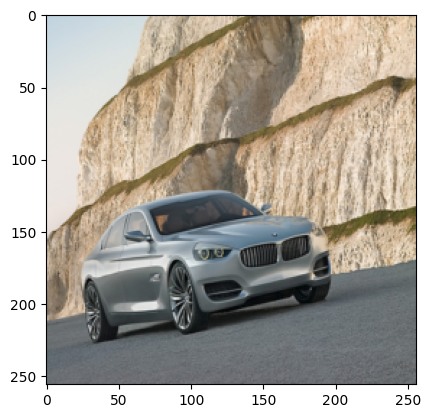

In [8]:
img_np = image0.permute(1, 2, 0).cpu().numpy().copy()
img_np = (img_np * 255).astype(np.uint8)  # (0~1) float → uint8
plt.imshow(img_np)

In [9]:
class CustomVOCDataset(Dataset):
    def __init__(self, root, image_set=None, transform=None) :
        self.root = root #PascalVOC 메인폴더의 경로
        # Main폴더의 4개 텍스트 파일로 설정할 모드(test, train, val, trainval)
        self.image_set = image_set 
        self.transform = transform

        # 경로 변수
        self.voc_root = os.path.join(root, 'VOCdevkit', 'VOC2012')
        self.annotation_path = os.path.join(root, 'VOCdevkit', 'VOC2012', 'Annotations')
        self.image_path = os.path.join(root, 'VOCdevkit', 'VOC2012', 'JPEGImages')
        self.split_file = os.path.join(self.voc_root, 'ImageSets', 'Main', image_set + '.txt')

        # 이미지 ID 목록 읽기
        with open(self.split_file) as f:
            file_ids = [line.strip() for line in f.readlines()]

        # 관심 클래스 정의
        self.target_classes = ['aeroplane', 'bicycle', 'bus', 'car', 'cat']
        
        # 파일 내에 있는 모든 object Element를 찾음.
        self.filtered_annotations_path = []
        self.filtered_images_path = []

        for file_id in file_ids :
            anno_path = os.path.join(self.annotation_path, file_id + '.xml')
            img_path = os.path.join(self.image_path, file_id + '.jpg')

            tree = ET.parse(anno_path)
            root = tree.getroot()
            objects = root.findall('object')

            # 클래스 필터링
            for obj in objects:
                class_name = obj.find('name').text
                if class_name in self.target_classes:
                    self.filtered_images_path.append(img_path)
                    self.filtered_annotations_path.append(anno_path)
                    break  # 하나라도 포함되면 그 이미지는 사용
        
    def __len__(self):
        return len(self.filtered_images_path)

    # target_classes에 대해서 바운딩 박스의 좌표, 클래스 인덱스, 총 객체의 수를 가져오는 함수
    def selected_parse_voc_xml(self, node):
        target_classes = ['aeroplane', 'bicycle', 'bus', 'car', 'cat']
        selected_boxes = []
        
        for obj in node.findall('object'):
            class_name = obj.find('name').text

            if class_name in target_classes :
                class_idx = target_classes.index(class_name)
                xml_box = obj.find('bndbox') 
                x1 = int(xml_box.find('xmin').text)
                y1 = int(xml_box.find('ymin').text)
                x2 = int(xml_box.find('xmax').text)
                y2 = int(xml_box.find('ymax').text)
                selected_boxes.append((x1, y1, x2, y2, class_idx))
                
        return selected_boxes

    # 종횡비를 곱한 새로운 바운딩 박스의 좌표를 반환
    def resizing_bbox(self, boxes, width_ratio, height_ratio) :
        resized_bbox = []
        
        for box in boxes:
            x1 = box[0] * width_ratio
            y1 = box[1] * height_ratio
            x2 = box[2] * width_ratio
            y2 = box[3] * height_ratio
            resized_bbox.append((x1, y1, x2, y2, box[4]))
        return resized_bbox
        
    def __getitem__(self, idx):
        #모드에 맞춰 필터링된 이미지, Annotations 정보를 불러오기
        image_path = self.filtered_images_path[idx]
        annotation_path = self.filtered_annotations_path[idx]

        # confidence, coordinate, size, class 정보가 담길 라벨 배열의 선언
        H,W=256,256 
        GHN,GWN=8,8
        GH,GW=int(H/GHN),int(W/GWN)
        Mmax=5 # maximum number of objects
        
        label_conf=np.zeros([1,GHN,GWN],dtype=np.float32) # confidence 정보가 담길 배열
        label_coord=np.zeros([2,GHN,GWN],dtype=np.float32) # 정규화된 해당 객체의 중심 좌표가 담길 배열
        label_size=np.zeros([2,GHN,GWN],dtype=np.float32) # 정규화된 해당 객체의 크기 정보가 담길 배열
        label_class=np.zeros([1,GHN,GWN],dtype=np.float32) # 해당 객체의 클래스 정보가 담길 배열

        # 1. 이미지 불러오기 및 변환 적용
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        # 2. XML 파일에서 어노테이션 정보 불러오기
        #xml 처리용 라이브러리로 root에 xml 정보를 저장함
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        
        #root로 처리된 xml정보로부터 [B_Box용 xy좌표 + 클래스 종류]추출
        boxes = self.selected_parse_voc_xml(root)

        # 3. 새로운 이미지의 크기에 대한 종횡비를 원래의 바운당 박스 좌표에 곱해주기
        image_size = root.find('size') # -> 자식 중 size 찾음 
        original_image_width = int(image_size.find('width').text) # size 를 찾고 그 자식노드인 width 를 찾아야 함. 
        original_image_height = int(image_size.find('height').text) # size 를 찾고 그 자식노드인 height 를 찾아야 함.
        
        width_ratio = W / original_image_width
        height_ratio = H / original_image_height

        resized_boxes = self.resizing_bbox(boxes, width_ratio, height_ratio)

        # # 4. label_size 정규화를 위해 bw, bh의 최댓값 찾기
        # bw_list = []
        # bh_list = []
        
        # for resized_box in resized_boxes :
        #     x = int((resized_box[0] + resized_box[2]) / 2)
        #     y = int((resized_box[1] + resized_box[3]) / 2)
        #     i, j = int(x/GW), int(y/GH)
        #     bw = resized_box[2] - resized_box[0]
        #     bh = resized_box[3] - resized_box[1]

        #     bw_list.append(bw)
        #     bh_list.append(bh)

        # bw_max = max(bw_list)
        # bh_max = max(bh_list)

        # 5. label_conf, label_coord, label_size, label_class 배열에 값을 대입
        for resized_box in resized_boxes :
            x = int((resized_box[0] + resized_box[2]) / 2)
            y = int((resized_box[1] + resized_box[3]) / 2)

            i, j = int(x/GW), int(y/GH)
            bw = resized_box[2] - resized_box[0]
            bh = resized_box[3] - resized_box[1]
            
            label_conf[0,j,i] = 1
            label_coord[0:2,j,i] = ((x-i*GW)/GW),((y-j*GH)/GH) # Normalized
            label_size[0:2,j,i]=(bw/W,bh/H) # Normalized
            label_class[0,j,i]=resized_box[4]
        
        return image, torch.from_numpy(label_conf), torch.from_numpy(label_coord), torch.from_numpy(label_size), torch.from_numpy(label_class)

## Train Dataset에 대해 이미지 증강 없이 학습 진행

In [10]:
# 이미지 증강 없이 학습 진행

from torchvision.transforms import v2

transformation = v2.Compose([
    v2.Resize((256, 256)), #이미지 크기를 256, 256로
    v2.ToTensor(),  # 이미지를 Tensor 자료형으로 변환
])

# 전처리 방법론 적용
train_subset_dataset = CustomVOCDataset(root='PascalVOC2012/', image_set='train', transform=transformation)
test_subset_dataset = CustomVOCDataset(root='PascalVOC2012/', image_set='val', transform=transformation)

# Train Dataset의 Size가 Test Dataset의 Size보다 작다
print(f"train dataset size : {len(train_subset_dataset)}")
print(f"test dataset size : {len(test_subset_dataset)}")

train dataset size : 1829
test dataset size : 1845


In [11]:
from torch.utils.data import DataLoader

BATCH_SIZE = 512

train_loader = DataLoader(train_subset_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_loader = DataLoader(test_subset_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

In [12]:
# Debugging...

image0, label_conf0, label_coord0, label_size0, label_class0 = train_subset_dataset[12]
print(label_conf0)
print("===========")
print(label_coord0)
print("===========")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.]]])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2812, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

In [13]:
# Debugging...

image0, label_conf0, label_coord0, label_size0, label_class0 = train_subset_dataset[12]
print(label_conf0)
print("===========")
print(label_size0)
print("===========")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.]]])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0940, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2160],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.9980, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

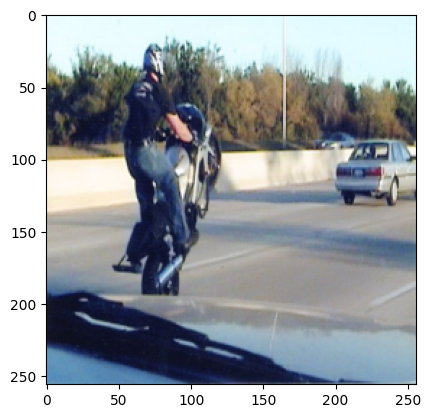

In [14]:
img_np = image0.permute(1, 2, 0).cpu().numpy().copy()
img_np = (img_np * 255).astype(np.uint8)  # (0~1) float → uint8
plt.imshow(img_np)

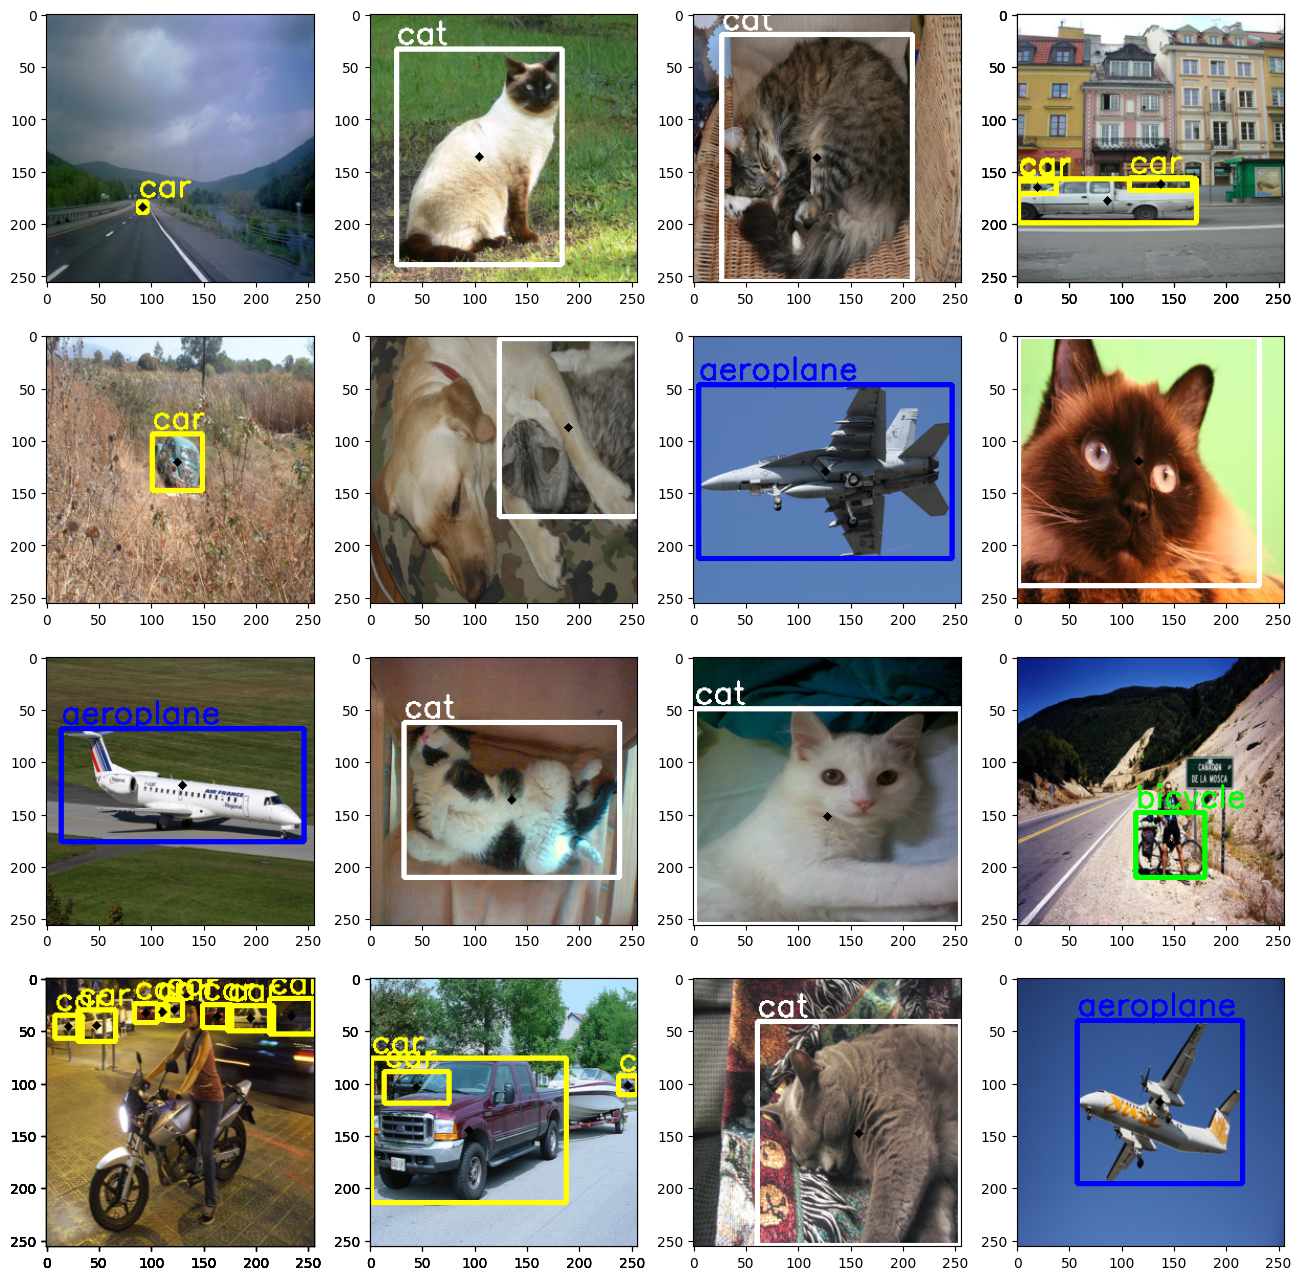

In [15]:
# train dataloader에 이미지가 잘 불러와 졌는지 확인하기
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import cv2

H,W=256,256 
GHN,GWN=8,8
GH,GW=int(H/GHN),int(W/GWN)
Mmax=5 # maximum number of objects

data_iter = iter(train_loader)
train_image, train_label_conf, train_label_coord, train_label_size, train_label_class = next(data_iter)

fig = plt.figure(figsize=(16,16))
rows=4
columns=4

# bw_max_list = []
# bh_max_list = []

# for n in range(1, rows * columns + 1) :
#     bw_list = []
#     bh_list = []
#     for i in range (GWN) :
#         for j in range (GHN) :
#             if train_label_conf[n-1, 0, j, i] == 1 :
#                 x=int(i*GW+(train_label_coord[n-1,0,j,i]*GW))
#                 y=int(j*GH+(train_label_coord[n-1,1,j,i]*GH))
#                 bw=int(train_label_size[n-1,0,j,i]*(W/4))
#                 bh=int(train_label_size[n-1,1,j,i]*(H/4))

#                 bw_list.append(bw)
#                 bh_list.append(bh)

#     bw_max_list.append(max(bw_list))
#     bh_max_list.append(max(bh_list))

# print(bw_max_list)
# print(bh_list)

for n in range(1, rows * columns + 1) :
    # Tensor → NumPy + 채널 순서 변경 (C,H,W) → (H,W,C)
    # permute() : 행렬의 차원을 맞교환 해주는 함수
    img_np = train_image[n-1].permute(1, 2, 0).cpu().numpy().copy()
    img_np = (img_np * 255).astype(np.uint8)  # (0~1) float → uint8
    for i in range (GWN) :
        for j in range (GHN) :
            if train_label_conf[n-1, 0, j, i] == 1 :
                x=int(i*GW+(train_label_coord[n-1,0,j,i]*GW))
                y=int(j*GH+(train_label_coord[n-1,1,j,i]*GH))
                bw=int(train_label_size[n-1,0,j,i]*W)
                bh=int(train_label_size[n-1,1,j,i]*H)
                obj_class=train_label_class[n-1,:,j,i]

                if obj_class==0: # aeroplane - blue
                    cv.rectangle(img_np,(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(0,0,255),thickness=3)
                    cv2.putText(img_np, 'aeroplane', (x-int(bw/2), y-int(bh/2) - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), thickness=2)
                elif obj_class==1: # bicycle - green
                    cv.rectangle(img_np,(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(0,255,0),thickness=3)
                    cv2.putText(img_np, 'bicycle', (x-int(bw/2), y-int(bh/2) - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), thickness=2)
                elif obj_class==2: # bus- red
                    cv.rectangle(img_np,(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(255,0,0),thickness=3)
                    cv2.putText(img_np, 'bus', (x-int(bw/2), y-int(bh/2) - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), thickness=2)
                elif obj_class==3: # car - yellow
                    cv.rectangle(img_np,(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(255,255,0),thickness=3)
                    cv2.putText(img_np, 'car', (x-int(bw/2), y-int(bh/2) - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,0), thickness=2)
                else : # cat - white
                    cv.rectangle(img_np,(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(255,255,255),thickness=3)
                    cv2.putText(img_np, 'cat', (x-int(bw/2), y-int(bh/2) - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
                    
                cv.circle(img_np,center=(x,y),radius=2,color=(0,0,0),thickness=3) # 해당 객체의 중앙을 표시
                
                fig.add_subplot(rows, columns, n)
                plt.imshow(img_np)

In [16]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) # GPU를 사용할 수 있는지 확인

cuda:0


In [13]:
# Step 1. VGG16 모델을 이용한 학습

In [11]:
import torchvision.models as models
import torch.nn as nn

vgg16 = models.vgg16(pretrained=True)

# Feature extracting layers만 불러오기 (fc 제외)
vgg16 = nn.Sequential(*list(vgg16.children())[:-2])

for param in vgg16.parameters():
    param.requires_grad = False

print(vgg16)

/home/jungseong/anaconda3/envs/vision/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jungseong/anaconda3/envs/vision/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

class VGG16MultipleDetector(nn.Module):
    def __init__(self, in_channels):
        super(VGG16MultipleDetector, self).__init__()
        # 기존의 Resnet18 모델을 base model로써 사용
        self.backbone = vgg16
        
        self.out_conf = nn.Conv2d(in_channels, out_channels=1, kernel_size=1)
        self.out_coord = nn.Conv2d(in_channels, out_channels=2, kernel_size=1)
        self.out_size = nn.Conv2d(in_channels, out_channels=2, kernel_size=1)
        self.out_class = nn.Conv2d(in_channels, out_channels=5, kernel_size=1) # output class의 수가 5

    def forward(self, x):
        x = self.backbone(x)
        out_conf = torch.sigmoid(self.out_conf(x))
        out_coord = torch.sigmoid(self.out_coord(x))
        out_size = torch.sigmoid(self.out_size(x))
        out_class = self.out_class(x)
        return out_conf, out_coord, out_size, out_class

my_model1 = VGG16MultipleDetector(512)
my_model1.to(device)

print(my_model1)

VGG16MultipleDetector(
  (backbone): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=T

In [13]:
import torch
import torch.nn.functional as F

# conf: (B, 1, H, W)
def conf_loss_func(y_pred, y_true):
    obj_mask = y_true[:, 0, :, :] == 1
    noobj_mask = ~obj_mask

    sqrerr = (y_pred - y_true) ** 2
    loss_obj_conf = torch.mean(sqrerr[:, 0, :, :][obj_mask])
    loss_noobj_conf = torch.mean(sqrerr[:, 0, :, :][noobj_mask])
    return 5 * loss_obj_conf + 0.5 * loss_noobj_conf

# coord: (B, 2, H, W)
# y_true[:, 0, :, :]는 object mask, y_true[:, 1:3, :, :]는 x, y 좌표
def coord_loss_func(y_pred, y_true):
    obj_mask = y_true[:, 0, :, :] == 1 # (B, H, W)
    coord_gt = y_true[:, 1:3, :, :]  # (B, 2, H, W)
    loss = F.mse_loss(y_pred, coord_gt, reduction='none')  # (B, 2, H, W)
    
    mask = obj_mask.unsqueeze(1)  # (B, H, W) -> (B, 1, H, W)의 형태로 차원을 늘려줌
    masked_loss = loss * mask # 브로드 캐스팅 규칙에 의해 (B, 1, H, W) -> (B, 2, H, W)로 복제되어 element-wise 연산이 가능하다
    return masked_loss.sum() / mask.sum()  # 평균 over valid elements

# size: (B, 2, H, W)
def size_loss_func(y_pred, y_true):
    obj_mask = y_true[:, 0, :, :] == 1
    size_gt = y_true[:, 1:3, :, :]
    loss = F.mse_loss(y_pred, size_gt, reduction='none')  # (B, 2, H, W)
    
    mask = obj_mask.unsqueeze(1)
    masked_loss = loss * mask
    return masked_loss.sum() / mask.sum()


# class: (B, 5, H, W) → softmaxed already
# y_true[:, 0, :, :] is object mask, y_true[:, 1, :, :] is class index (long)
def class_loss_func(y_pred, y_true):
    obj_mask = y_true[:, 0, :, :] == 1
    class_gt = y_true[:, 1, :, :].long()
    loss = F.cross_entropy(y_pred, class_gt, reduction='none')

    mask = obj_mask.float()
    masked_loss = loss * mask
    return masked_loss.sum() / mask.sum()

In [14]:
class CustomLoss(torch.nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        self.weights = weights or {
            'conf': 3,
            'coord': 4,
            'size': 2,
            'class': 1
        }

    def forward(self, out, target):
        out_conf, out_coord, out_size, out_class = out
        target_conf, target_coord, target_size, target_class = target

        loss_conf = conf_loss_func(out_conf, target_conf)
        loss_coord = coord_loss_func(out_coord, target_coord)
        loss_size = size_loss_func(out_size, target_size)
        loss_class = class_loss_func(out_class, target_class)

        total_loss = (
            self.weights['conf'] * loss_conf +
            self.weights['coord'] * loss_coord +
            self.weights['size'] * loss_size +
            self.weights['class'] * loss_class
        )

        return total_loss, {
            'conf': loss_conf,
            'coord': loss_coord,
            'size': loss_size,
            'class': loss_class
        }

In [15]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(my_model1.parameters(), lr=learning_rate)

print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [16]:
# 하나의 배치에 대해서만 train_dataset을 학습해 봤고, 엄청나게는 아니지만 그래도 어느정도 loss가 떨어지는 것을 확인할 수 있다

num_epochs = 2000

train_total_loss_list = []
train_label_conf_loss_list = []
train_label_coord_loss_list = []
train_label_size_loss_list = []
train_label_class_loss_list = []

loss_fn = CustomLoss()

for epoch in range(num_epochs):
    my_model1.train() # VGG16을 backbone으로 사용한 모델을 train
    
    epoch_total_loss = 0.0
    epoch_conf_loss = 0.0
    epoch_coord_loss = 0.0
    epoch_size_loss = 0.0
    epoch_class_loss = 0.0

    cnt = 0

    images, label_conf, label_coord, label_size, label_class = next(iter(train_loader))
    images = images.to(device) 
    label_conf = label_conf.to(device)
    label_coord = label_coord.to(device)
    label_size = label_size.to(device)
    label_class = label_class.to(device)
    
    out_conf, out_coord, out_size, out_class = my_model1(images) 
    
    total_loss, loss_dict = loss_fn(
        (out_conf, out_coord, out_size, out_class),
        (
            label_conf,
            torch.cat([label_conf, label_coord], dim=1),
            torch.cat([label_conf, label_size], dim=1),
            torch.cat([label_conf, label_class], dim=1)
        )
    )

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # epoch 평균용 float만 따로 저장
    epoch_total_loss += total_loss.item()
    epoch_conf_loss += loss_dict['conf'].item()
    epoch_coord_loss += loss_dict['coord'].item()
    epoch_size_loss += loss_dict['size'].item()
    epoch_class_loss += loss_dict['class'].item()
    cnt += 1

    # 배치 개수로 평균
    train_total_loss_list.append(epoch_total_loss / cnt)
    train_label_conf_loss_list.append(epoch_conf_loss / cnt)
    train_label_coord_loss_list.append(epoch_coord_loss / cnt)
    train_label_size_loss_list.append(epoch_size_loss / cnt)
    train_label_class_loss_list.append(epoch_class_loss / cnt)

    if (epoch % 50 == 0) :
        print(f"[Epoch {epoch+1}] Avg Train Loss: {epoch_total_loss / cnt:.4f} | conf_loss: {epoch_conf_loss / cnt:.4f}, coord_loss: {epoch_coord_loss / cnt:.4f}, size_loss: {epoch_size_loss / cnt:.4f}, class_loss: {epoch_class_loss / cnt:.4f}")

[Epoch 1] Avg Train Loss: 15.2404 | conf_loss: 1.1176, coord_loss: 0.2891, size_loss: 4.5943, class_loss: 1.5424
[Epoch 51] Avg Train Loss: 14.0944 | conf_loss: 0.8222, coord_loss: 0.1900, size_loss: 4.7106, class_loss: 1.4467
[Epoch 101] Avg Train Loss: 14.8677 | conf_loss: 0.4858, coord_loss: 0.2611, size_loss: 5.5541, class_loss: 1.2578
[Epoch 151] Avg Train Loss: 10.5642 | conf_loss: 0.4562, coord_loss: 0.2093, size_loss: 3.6435, class_loss: 1.0712
[Epoch 201] Avg Train Loss: 10.5512 | conf_loss: 0.4807, coord_loss: 0.1736, size_loss: 3.6146, class_loss: 1.1854
[Epoch 251] Avg Train Loss: 12.0997 | conf_loss: 0.4313, coord_loss: 0.2471, size_loss: 4.3887, class_loss: 1.0401
[Epoch 301] Avg Train Loss: 9.9739 | conf_loss: 0.3927, coord_loss: 0.2070, size_loss: 3.5193, class_loss: 0.9293
[Epoch 351] Avg Train Loss: 12.5941 | conf_loss: 0.4290, coord_loss: 0.1916, size_loss: 4.7203, class_loss: 1.1003
[Epoch 401] Avg Train Loss: 10.4301 | conf_loss: 0.3479, coord_loss: 0.1795, size_lo

KeyboardInterrupt: 

In [17]:
# Step 2. ResNet18 모델을 이용한 학습

In [18]:
import torchvision.models as models
import torch.nn as nn

resnet18 = models.resnet18(pretrained=True)

# Feature extracting layers만 불러오기 (fc 제외)
resnet18 = nn.Sequential(*list(resnet18.children())[:-2])

for param in resnet18.parameters():
    param.requires_grad = False

print(resnet18)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

/home/jungseong/anaconda3/envs/vision/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jungseong/anaconda3/envs/vision/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet18MultipleDetector(nn.Module):
    def __init__(self, in_channels):
        super(ResNet18MultipleDetector, self).__init__()
        # 기존의 Resnet18 모델을 base model로써 사용
        self.backbone = resnet18
        
        self.out_conf = nn.Conv2d(in_channels, out_channels=1, kernel_size=1)
        self.out_coord = nn.Conv2d(in_channels, out_channels=2, kernel_size=1)
        self.out_size = nn.Conv2d(in_channels, out_channels=2, kernel_size=1)
        self.out_class = nn.Conv2d(in_channels, out_channels=5, kernel_size=1) # output class의 수가 5

    def forward(self, x):
        x = self.backbone(x)
        out_conf = torch.sigmoid(self.out_conf(x))
        out_coord = torch.sigmoid(self.out_coord(x))
        out_size = torch.sigmoid(self.out_size(x))
        out_class = self.out_class(x)
        return out_conf, out_coord, out_size, out_class

my_model2 = ResNet18MultipleDetector(512)
my_model2.to(device)

print(my_model2)

ResNet18MultipleDetector(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [20]:
import torch
import torch.nn.functional as F

# conf: (B, 1, H, W)
def conf_loss_func(y_pred, y_true):
    obj_mask = y_true[:, 0, :, :] == 1
    noobj_mask = ~obj_mask

    sqrerr = (y_pred - y_true) ** 2
    loss_obj_conf = torch.mean(sqrerr[:, 0, :, :][obj_mask])
    loss_noobj_conf = torch.mean(sqrerr[:, 0, :, :][noobj_mask])
    return 5 * loss_obj_conf + 0.5 * loss_noobj_conf

# coord: (B, 2, H, W)
# y_true[:, 0, :, :]는 object mask, y_true[:, 1:3, :, :]는 x, y 좌표
def coord_loss_func(y_pred, y_true):
    obj_mask = y_true[:, 0, :, :] == 1 # (B, H, W)
    coord_gt = y_true[:, 1:3, :, :]  # (B, 2, H, W)
    loss = F.mse_loss(y_pred, coord_gt, reduction='none')  # (B, 2, H, W)
    
    mask = obj_mask.unsqueeze(1)  # (B, H, W) -> (B, 1, H, W)의 형태로 차원을 늘려줌
    masked_loss = loss * mask # 브로드 캐스팅 규칙에 의해 (B, 1, H, W) -> (B, 2, H, W)로 복제되어 element-wise 연산이 가능하다
    return masked_loss.sum() / mask.sum()  # 평균 over valid elements

# size: (B, 2, H, W)
def size_loss_func(y_pred, y_true):
    obj_mask = y_true[:, 0, :, :] == 1
    size_gt = y_true[:, 1:3, :, :]
    loss = F.mse_loss(y_pred, size_gt, reduction='none')  # (B, 2, H, W)
    
    mask = obj_mask.unsqueeze(1)
    masked_loss = loss * mask
    return masked_loss.sum() / mask.sum()


# class: (B, 5, H, W) → softmaxed already
# y_true[:, 0, :, :] is object mask, y_true[:, 1, :, :] is class index (long)
def class_loss_func(y_pred, y_true):
    obj_mask = y_true[:, 0, :, :] == 1
    class_gt = y_true[:, 1, :, :].long()
    loss = F.cross_entropy(y_pred, class_gt, reduction='none')

    mask = obj_mask.float()
    masked_loss = loss * mask
    return masked_loss.sum() / mask.sum()

In [21]:
class CustomLoss(torch.nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        self.weights = weights or {
            'conf': 4,
            'coord': 4,
            'size': 2,
            'class': 1
        }

    def forward(self, out, target):
        out_conf, out_coord, out_size, out_class = out
        target_conf, target_coord, target_size, target_class = target

        loss_conf = conf_loss_func(out_conf, target_conf)
        loss_coord = coord_loss_func(out_coord, target_coord)
        loss_size = size_loss_func(out_size, target_size)
        loss_class = class_loss_func(out_class, target_class)

        total_loss = (
            self.weights['conf'] * loss_conf +
            self.weights['coord'] * loss_coord +
            self.weights['size'] * loss_size +
            self.weights['class'] * loss_class
        )

        return total_loss, {
            'conf': loss_conf,
            'coord': loss_coord,
            'size': loss_size,
            'class': loss_class
        }

In [22]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(my_model2.parameters(), lr=learning_rate)

print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [20]:
# 하나의 배치에 대해서만 train_dataset을 학습해 봤고, 엄청나게는 아니지만 그래도 어느정도 loss가 떨어지는 것을 확인할 수 있다

num_epochs = 2000

train_total_loss_list = []
train_label_conf_loss_list = []
train_label_coord_loss_list = []
train_label_size_loss_list = []
train_label_class_loss_list = []

loss_fn = CustomLoss()

for epoch in range(num_epochs):
    my_model2.train() # ResNet18을 backbone으로 사용한 모델을 train
    
    epoch_total_loss = 0.0
    epoch_conf_loss = 0.0
    epoch_coord_loss = 0.0
    epoch_size_loss = 0.0
    epoch_class_loss = 0.0

    cnt = 0

    images, label_conf, label_coord, label_size, label_class = next(iter(train_loader))
    images = images.to(device)
    label_conf = label_conf.to(device)
    label_coord = label_coord.to(device)
    label_size = label_size.to(device)
    label_class = label_class.to(device)
    
    out_conf, out_coord, out_size, out_class = my_model2(images) 
    
    total_loss, loss_dict = loss_fn(
        (out_conf, out_coord, out_size, out_class),
        (
            label_conf,
            torch.cat([label_conf, label_coord], dim=1),
            torch.cat([label_conf, label_size], dim=1),
            torch.cat([label_conf, label_class], dim=1)
        )
    )

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # epoch 평균용 float만 따로 저장
    epoch_total_loss += total_loss.item()
    epoch_conf_loss += loss_dict['conf'].item()
    epoch_coord_loss += loss_dict['coord'].item()
    epoch_size_loss += loss_dict['size'].item()
    epoch_class_loss += loss_dict['class'].item()
    cnt += 1

    # 배치 개수로 평균
    train_total_loss_list.append(epoch_total_loss / cnt)
    train_label_conf_loss_list.append(epoch_conf_loss / cnt)
    train_label_coord_loss_list.append(epoch_coord_loss / cnt)
    train_label_size_loss_list.append(epoch_size_loss / cnt)
    train_label_class_loss_list.append(epoch_class_loss / cnt)

    if (epoch % 50 == 0) :
        print(f"[Epoch {epoch+1}] Avg Train Loss: {epoch_total_loss / cnt:.4f} | conf_loss: {epoch_conf_loss / cnt:.4f}, coord_loss: {epoch_coord_loss / cnt:.4f}, size_loss: {epoch_size_loss / cnt:.4f}, class_loss: {epoch_class_loss / cnt:.4f}")

[Epoch 1] Avg Train Loss: 10.3302 | conf_loss: 1.5208, coord_loss: 0.3511, size_loss: 0.3479, class_loss: 2.1468


KeyboardInterrupt: 

In [23]:
# Train Dataset + Test Dataset에 대해 모델 적용

num_epochs = 2000

# Train loss lists
train_total_loss_list = []
train_label_conf_loss_list = []
train_label_coord_loss_list = []
train_label_size_loss_list = []
train_label_class_loss_list = []

# Test loss lists
test_total_loss_list = []
test_label_conf_loss_list = []
test_label_coord_loss_list = []
test_label_size_loss_list = []
test_label_class_loss_list = []

loss_fn = CustomLoss()

for epoch in range(num_epochs):
    my_model2.train() # ResNet18을 backbone으로 사용한 모델로 train
    
    train_epoch_total_loss = 0.0
    train_epoch_conf_loss = 0.0
    train_epoch_coord_loss = 0.0
    train_epoch_size_loss = 0.0
    train_epoch_class_loss = 0.0

    train_cnt = 0

    for images, label_conf, label_coord, label_size, label_class in train_loader :
        images = images.to(device)
        label_conf = label_conf.to(device)
        label_coord = label_coord.to(device)
        label_size = label_size.to(device)
        label_class = label_class.to(device)
        
        out_conf, out_coord, out_size, out_class = my_model2(images) 
        
        total_loss, loss_dict = loss_fn(
            (out_conf, out_coord, out_size, out_class),
            (
                label_conf,
                torch.cat([label_conf, label_coord], dim=1),
                torch.cat([label_conf, label_size], dim=1),
                torch.cat([label_conf, label_class], dim=1)
            )
        )
    
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # epoch 평균용 float만 따로 저장
        train_epoch_total_loss += total_loss.item()
        train_epoch_conf_loss += loss_dict['conf'].item()
        train_epoch_coord_loss += loss_dict['coord'].item()
        train_epoch_size_loss += loss_dict['size'].item()
        train_epoch_class_loss += loss_dict['class'].item()
        
        train_cnt += 1

    # 배치 개수로 평균
    train_total_loss_list.append(train_epoch_total_loss / train_cnt)
    train_label_conf_loss_list.append(train_epoch_conf_loss / train_cnt)
    train_label_coord_loss_list.append(train_epoch_coord_loss / train_cnt)
    train_label_size_loss_list.append(train_epoch_size_loss / train_cnt)
    train_label_class_loss_list.append(train_epoch_class_loss / train_cnt)

    my_model2.eval() # ResNet18을 backbone으로 사용한 모델로 test
    
    test_epoch_total_loss = 0.0
    test_epoch_conf_loss = 0.0
    test_epoch_coord_loss = 0.0
    test_epoch_size_loss = 0.0
    test_epoch_class_loss = 0.0

    test_cnt = 0

    with torch.no_grad(): # 기울기 업데이트 비활성화
        for images, label_conf, label_coord, label_size, label_class in test_loader :
            images = images.to(device)
            label_conf = label_conf.to(device)
            label_coord = label_coord.to(device)
            label_size = label_size.to(device)
            label_class = label_class.to(device)
            
            out_conf, out_coord, out_size, out_class = my_model2(images) 
            
            total_loss, loss_dict = loss_fn(
                (out_conf, out_coord, out_size, out_class),
                (
                    label_conf,
                    torch.cat([label_conf, label_coord], dim=1),
                    torch.cat([label_conf, label_size], dim=1),
                    torch.cat([label_conf, label_class], dim=1)
                )
            )
            
            # epoch 평균용 float만 따로 저장
            test_epoch_total_loss += total_loss.item()
            test_epoch_conf_loss += loss_dict['conf'].item()
            test_epoch_coord_loss += loss_dict['coord'].item()
            test_epoch_size_loss += loss_dict['size'].item()
            test_epoch_class_loss += loss_dict['class'].item()
            test_cnt += 1

    # 배치 개수로 평균
    test_total_loss_list.append(test_epoch_total_loss / test_cnt)
    test_label_conf_loss_list.append(test_epoch_conf_loss / test_cnt)
    test_label_coord_loss_list.append(test_epoch_coord_loss / test_cnt)
    test_label_size_loss_list.append(test_epoch_size_loss / test_cnt)
    test_label_class_loss_list.append(test_epoch_class_loss / test_cnt)

    if (epoch % 50 == 0) :
        print(f"[Epoch {epoch+1}] Avg Train Loss: {train_epoch_total_loss / train_cnt:.4f} | conf_loss: {train_epoch_conf_loss / train_cnt:.4f}, coord_loss: {train_epoch_coord_loss / train_cnt:.4f}, size_loss: {train_epoch_size_loss / train_cnt:.4f}, class_loss: {train_epoch_class_loss / train_cnt:.4f}")
        print("=="*40)
        print(f"[Epoch {epoch+1}] Avg Test Loss: {test_epoch_total_loss / test_cnt:.4f} | conf_loss: {test_epoch_conf_loss / test_cnt:.4f}, coord_loss: {test_epoch_coord_loss / test_cnt:.4f}, size_loss: {test_epoch_size_loss / test_cnt:.4f}, class_loss: {test_epoch_class_loss / test_cnt:.4f}")
        print("=="*40)

[Epoch 1] Avg Train Loss: 10.3408 | conf_loss: 1.4684, coord_loss: 0.3621, size_loss: 0.3441, class_loss: 2.3305
[Epoch 1] Avg Test Loss: 9.8469 | conf_loss: 1.4650, coord_loss: 0.3104, size_loss: 0.3417, class_loss: 2.0619
[Epoch 51] Avg Train Loss: 3.3618 | conf_loss: 0.4123, coord_loss: 0.2244, size_loss: 0.1292, class_loss: 0.5566
[Epoch 51] Avg Test Loss: 3.4342 | conf_loss: 0.4117, coord_loss: 0.2367, size_loss: 0.1323, class_loss: 0.5761
[Epoch 101] Avg Train Loss: 2.9351 | conf_loss: 0.4008, coord_loss: 0.1940, size_loss: 0.0911, class_loss: 0.3737
[Epoch 101] Avg Test Loss: 3.1032 | conf_loss: 0.4017, coord_loss: 0.2180, size_loss: 0.1016, class_loss: 0.4210
[Epoch 151] Avg Train Loss: 2.7225 | conf_loss: 0.3897, coord_loss: 0.1758, size_loss: 0.0758, class_loss: 0.3090
[Epoch 151] Avg Test Loss: 2.9492 | conf_loss: 0.3903, coord_loss: 0.2083, size_loss: 0.0898, class_loss: 0.3751
[Epoch 201] Avg Train Loss: 2.5739 | conf_loss: 0.3763, coord_loss: 0.1654, size_loss: 0.0669, cl

KeyboardInterrupt: 

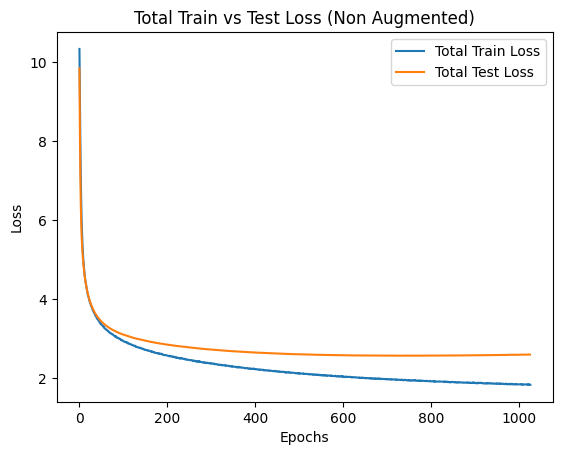

In [33]:
# plot train-test loss graph

plt.plot(range(len(train_total_loss_list)), train_total_loss_list, label="Total Train Loss")
plt.plot(range(len(test_total_loss_list)), test_total_loss_list, label="Total Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Total Train vs Test Loss (Non Augmented)")
plt.legend()
plt.show()

## 데이터 증강 기법으로 Train Dataset의 종류를 늘려 학습시키기

In [4]:
# import libraries

import torchvision
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.transforms.functional import to_tensor, to_pil_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import tensorflow as tf
import cv2 as cv
import random
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET # 이걸 이용해 파싱

# 이미지 증강을 위한 라이브러리 선언
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as v2

In [5]:
class CustomVOCDataset(Dataset):
    def __init__(self, root, image_set=None, transform=None) :
        self.root = root #PascalVOC 메인폴더의 경로
        # Main폴더의 4개 텍스트 파일로 설정할 모드(test, train, val, trainval)
        self.image_set = image_set
        self.transform = transform

        # 경로 변수
        self.voc_root = os.path.join(root, 'VOCdevkit', 'VOC2012')
        self.annotation_path = os.path.join(root, 'VOCdevkit', 'VOC2012', 'Annotations')
        self.image_path = os.path.join(root, 'VOCdevkit', 'VOC2012', 'JPEGImages')
        self.split_file = os.path.join(self.voc_root, 'ImageSets', 'Main', image_set + '.txt')

        # 이미지 ID 목록 읽기
        with open(self.split_file) as f:
            file_ids = [line.strip() for line in f.readlines()]

        # 관심 클래스 정의
        self.target_classes = ['aeroplane', 'bicycle', 'bus', 'car', 'cat']

        # 파일 내에 있는 모든 object Element를 찾음.
        self.filtered_annotations_path = []
        self.filtered_images_path = []

        for file_id in file_ids :
            anno_path = os.path.join(self.annotation_path, file_id + '.xml')
            img_path = os.path.join(self.image_path, file_id + '.jpg')

            tree = ET.parse(anno_path)
            root = tree.getroot()
            objects = root.findall('object')

            # 클래스 필터링
            for obj in objects:
                class_name = obj.find('name').text
                if class_name in self.target_classes:
                    self.filtered_images_path.append(img_path)
                    self.filtered_annotations_path.append(anno_path)
                    break  # 하나라도 포함되면 그 이미지는 사용

    def __len__(self):
        return len(self.filtered_images_path)

    # target_classes에 대해서 바운딩 박스의 좌표, 클래스 인덱스, 총 객체의 수를 가져오는 함수
    def selected_parse_voc_xml(self, node):
        target_classes = ['aeroplane', 'bicycle', 'bus', 'car', 'cat']
        selected_boxes = []

        for obj in node.findall('object'):
            class_name = obj.find('name').text

            if class_name in target_classes :
                class_idx = target_classes.index(class_name)
                xml_box = obj.find('bndbox')
                x1 = int(xml_box.find('xmin').text)
                y1 = int(xml_box.find('ymin').text)
                x2 = int(xml_box.find('xmax').text)
                y2 = int(xml_box.find('ymax').text)
                selected_boxes.append((x1, y1, x2, y2, class_idx))

        return selected_boxes

    def __getitem__(self, idx):
      image_path = self.filtered_images_path[idx]
      annotation_path = self.filtered_annotations_path[idx]

      # 이미지 원본 크기
      H, W = 256, 256
      GHN, GWN = 8, 8
      GH, GW = int(H / GHN), int(W / GWN)

      label_conf = np.zeros([1, GHN, GWN], dtype=np.float32)
      label_coord = np.zeros([2, GHN, GWN], dtype=np.float32)
      label_size = np.zeros([2, GHN, GWN], dtype=np.float32)
      label_class = np.zeros([1, GHN, GWN], dtype=np.float32)

      # 이미지 로딩
      image = np.array(Image.open(image_path).convert("RGB"), dtype=np.uint8)

      # Annotation 로딩
      tree = ET.parse(annotation_path)
      root = tree.getroot()
      boxes = self.selected_parse_voc_xml(root)

      # Albumentations 포맷으로 변환
      bboxes = []
      class_labels = []

      for box in boxes:
          x1, y1, x2, y2, class_idx = box
          bboxes.append([x1, y1, x2, y2])  # Pascal VOC format
          class_labels.append(class_idx)

      # Albumentations transform 적용
      if self.transform:
          transformed = self.transform(image=image, bboxes=bboxes, class_labels=class_labels)
          image = transformed['image']  # Tensor (C, H, W)
          bboxes = transformed['bboxes']
          class_labels = transformed['class_labels']
      else:
          image = ToTensorV2()(image=image)['image']
          bboxes = [box[:4] for box in boxes]
          class_labels = [box[4] for box in boxes]

      # 라벨 매핑
      for bbox, cls in zip(bboxes, class_labels):
          x1, y1, x2, y2 = bbox
          x = int((x1 + x2) / 2)
          y = int((y1 + y2) / 2)
          bw = x2 - x1
          bh = y2 - y1

          i, j = int(x / GW), int(y / GH)

          if 0 <= i < GWN and 0 <= j < GHN:
              label_conf[0, j, i] = 1
              label_coord[0:2, j, i] = ((x - i * GW) / GW, (y - j * GH) / GH)
              label_size[0:2, j, i] = (bw / W, bh / H)
              label_class[0, j, i] = cls

      return image, torch.from_numpy(label_conf), torch.from_numpy(label_coord), torch.from_numpy(label_size), torch.from_numpy(label_class)

In [6]:
# Albumentation은 바운딩 박스의 크기를 이미지의 변환에 맞게 자동으로 리사이징 해준다.

train_transformation = A.Compose([
    A.Resize(256, 256), #이미지 크기를 256, 256로
    A.HorizontalFlip(p=0.3),
    A.Rotate(limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), p=0.3),
    ToTensorV2(),  # 이미지를 Tensor 자료형으로 변환
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

test_transformation = A.Compose([
    A.Resize(256, 256),
    ToTensorV2()
])

# 전처리 방법론 적용
augmented_train_subset_dataset = CustomVOCDataset(root='PascalVOC2012/', image_set='train', transform=train_transformation)
test_subset_dataset = CustomVOCDataset(root='PascalVOC2012/', image_set='val', transform=test_transformation)

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 512

augmented_train_loader = DataLoader(augmented_train_subset_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
test_loader = DataLoader(test_subset_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

torch.uint8


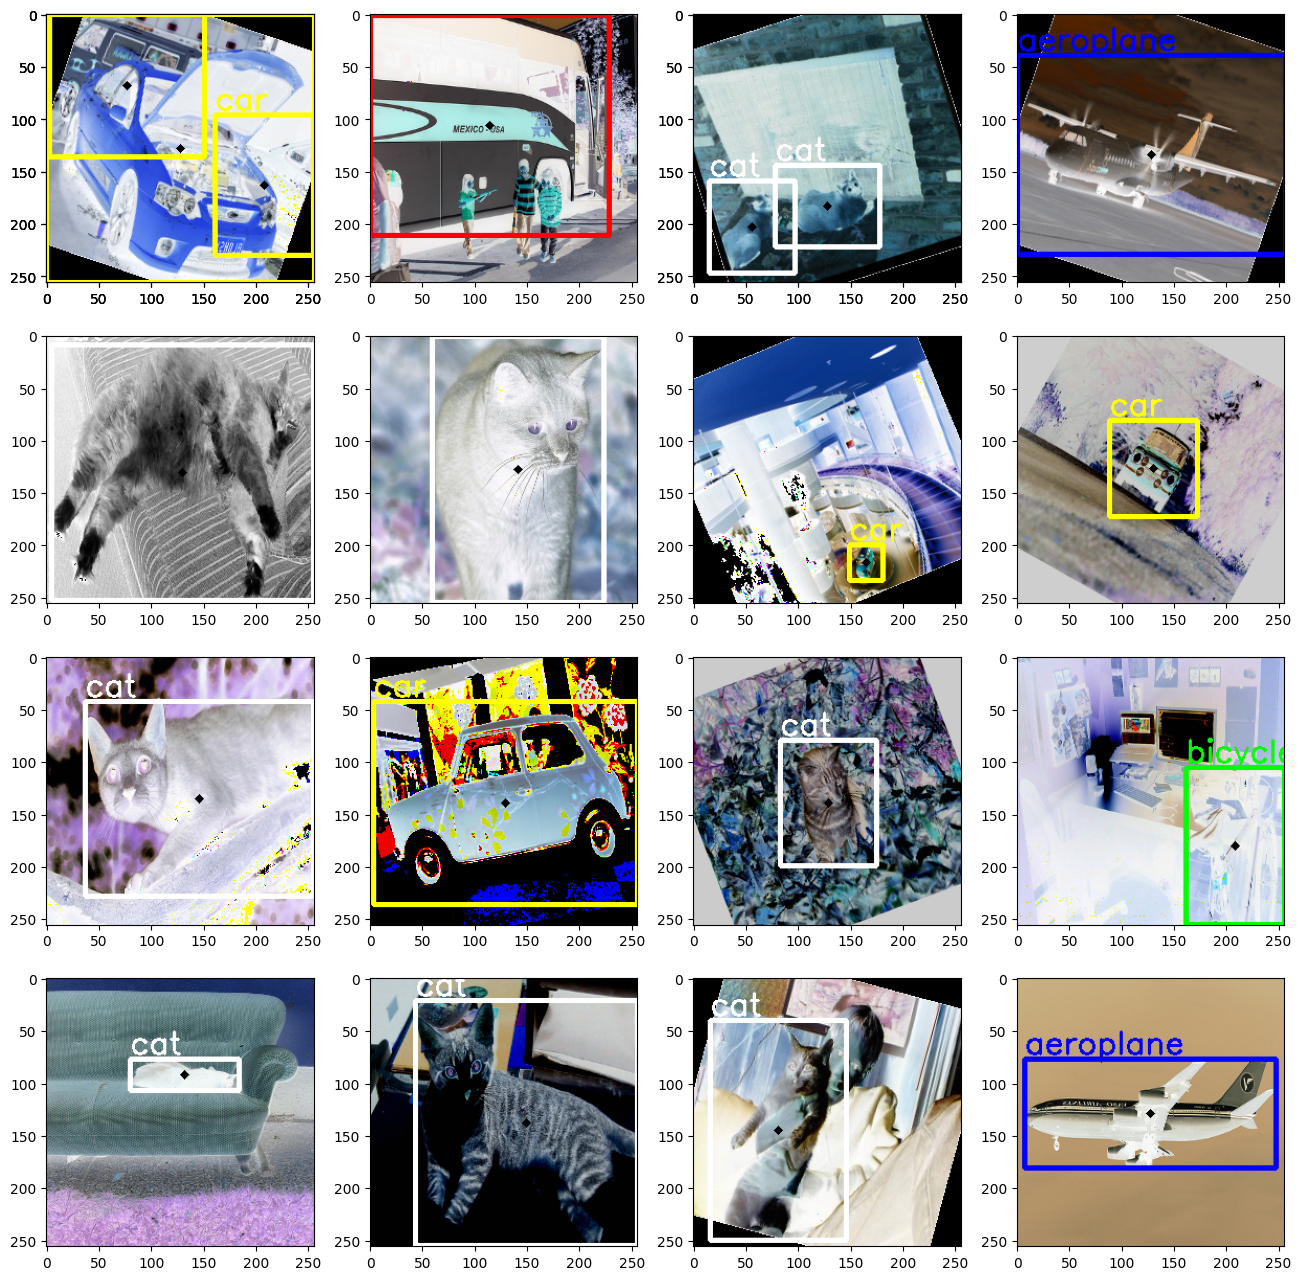

In [8]:
# train dataloader에 이미지가 잘 불러와 졌는지 확인하기
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import cv2

H,W=256,256
GHN,GWN=8,8
GH,GW=int(H/GHN),int(W/GWN)
Mmax=5 # maximum number of objects

data_iter = iter(augmented_train_loader)
train_image, train_label_conf, train_label_coord, train_label_size, train_label_class = next(data_iter)

print(train_image.dtype)

fig = plt.figure(figsize=(16,16))
rows=4
columns=4

# bw_max_list = []
# bh_max_list = []

# for n in range(1, rows * columns + 1) :
#     bw_list = []
#     bh_list = []
#     for i in range (GWN) :
#         for j in range (GHN) :
#             if train_label_conf[n-1, 0, j, i] == 1 :
#                 x=int(i*GW+(train_label_coord[n-1,0,j,i]*GW))
#                 y=int(j*GH+(train_label_coord[n-1,1,j,i]*GH))
#                 bw=int(train_label_size[n-1,0,j,i]*(W/4))
#                 bh=int(train_label_size[n-1,1,j,i]*(H/4))

#                 bw_list.append(bw)
#                 bh_list.append(bh)

#     bw_max_list.append(max(bw_list))
#     bh_max_list.append(max(bh_list))

# print(bw_max_list)
# print(bh_list)

for n in range(1, rows * columns + 1) :
    # Tensor → NumPy + 채널 순서 변경 (C,H,W) → (H,W,C)
    # permute() : 행렬의 차원을 맞교환 해주는 함수
    img_np = train_image[n-1].permute(1, 2, 0).cpu().numpy().copy()
    img_np = (img_np * 255).astype(np.uint8)  # (0~1) float → uint8
    for i in range (GWN) :
        for j in range (GHN) :
            if train_label_conf[n-1, 0, j, i] == 1 :
                x=int(i*GW+(train_label_coord[n-1,0,j,i]*GW))
                y=int(j*GH+(train_label_coord[n-1,1,j,i]*GH))
                bw=int(train_label_size[n-1,0,j,i]*W)
                bh=int(train_label_size[n-1,1,j,i]*H)
                obj_class=train_label_class[n-1,:,j,i]

                if obj_class==0: # aeroplane - blue
                    cv.rectangle(img_np,(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(0,0,255),thickness=3)
                    cv2.putText(img_np, 'aeroplane', (x-int(bw/2), y-int(bh/2) - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), thickness=2)
                elif obj_class==1: # bicycle - green
                    cv.rectangle(img_np,(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)), color=(0,255,0),thickness=3)
                    cv2.putText(img_np, 'bicycle', (x-int(bw/2), y-int(bh/2) - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), thickness=2)
                elif obj_class==2: # bus- red
                    cv.rectangle(img_np,(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(255,0,0),thickness=3)
                    cv2.putText(img_np, 'bus', (x-int(bw/2), y-int(bh/2) - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), thickness=2)
                elif obj_class==3: # car - yellow
                    cv.rectangle(img_np,(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(255,255,0),thickness=3)
                    cv2.putText(img_np, 'car', (x-int(bw/2), y-int(bh/2) - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,0), thickness=2)
                else : # cat - white
                    cv.rectangle(img_np,(x-int(bw/2),y-int(bh/2)),(x+int(bw/2),y+int(bh/2)),color=(255,255,255),thickness=3)
                    cv2.putText(img_np, 'cat', (x-int(bw/2), y-int(bh/2) - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)

                cv.circle(img_np,center=(x,y),radius=2,color=(0,0,0),thickness=3) # 해당 객체의 중앙을 표시

                fig.add_subplot(rows, columns, n)
                plt.imshow(img_np)

In [9]:
import torchvision.models as models
import torch.nn as nn

resnet18 = models.resnet18(pretrained=True)

# Feature extracting layers만 불러오기 (fc 제외)
resnet18 = nn.Sequential(*list(resnet18.children())[:-2])

for param in resnet18.parameters():
    param.requires_grad = False

print(resnet18)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

/home/jungseong/anaconda3/envs/vision/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jungseong/anaconda3/envs/vision/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) # GPU를 사용할 수 있는지 확인

cuda:0


In [11]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet18MultipleDetector(nn.Module):
    def __init__(self, in_channels):
        super(ResNet18MultipleDetector, self).__init__()
        # 기존의 Resnet18 모델을 base model로써 사용
        self.backbone = resnet18

        self.out_conf = nn.Conv2d(in_channels, out_channels=1, kernel_size=1)
        self.out_coord = nn.Conv2d(in_channels, out_channels=2, kernel_size=1)
        self.out_size = nn.Conv2d(in_channels, out_channels=2, kernel_size=1)
        self.out_class = nn.Conv2d(in_channels, out_channels=5, kernel_size=1) # output class의 수가 5

    def forward(self, x):
        x = self.backbone(x)
        out_conf = torch.sigmoid(self.out_conf(x))
        out_coord = torch.sigmoid(self.out_coord(x))
        out_size = torch.sigmoid(self.out_size(x))
        out_class = self.out_class(x)
        return out_conf, out_coord, out_size, out_class

my_model2 = ResNet18MultipleDetector(512)
my_model2.to(device)

print(my_model2)

ResNet18MultipleDetector(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [12]:
import torch
import torch.nn.functional as F

# conf: (B, 1, H, W)
def conf_loss_func(y_pred, y_true):
    obj_mask = y_true[:, 0, :, :] == 1
    noobj_mask = ~obj_mask

    sqrerr = (y_pred - y_true) ** 2
    loss_obj_conf = torch.mean(sqrerr[:, 0, :, :][obj_mask])
    loss_noobj_conf = torch.mean(sqrerr[:, 0, :, :][noobj_mask])
    return 5 * loss_obj_conf + 0.5 * loss_noobj_conf

# coord: (B, 2, H, W)
# y_true[:, 0, :, :]는 object mask, y_true[:, 1:3, :, :]는 x, y 좌표
def coord_loss_func(y_pred, y_true):
    obj_mask = y_true[:, 0, :, :] == 1 # (B, H, W)
    coord_gt = y_true[:, 1:3, :, :]  # (B, 2, H, W)
    loss = F.mse_loss(y_pred, coord_gt, reduction='none')  # (B, 2, H, W)

    mask = obj_mask.unsqueeze(1)  # (B, H, W) -> (B, 1, H, W)의 형태로 차원을 늘려줌
    masked_loss = loss * mask # 브로드 캐스팅 규칙에 의해 (B, 1, H, W) -> (B, 2, H, W)로 복제되어 element-wise 연산이 가능하다
    return masked_loss.sum() / mask.sum()  # 평균 over valid elements

# size: (B, 2, H, W)
def size_loss_func(y_pred, y_true):
    obj_mask = y_true[:, 0, :, :] == 1
    size_gt = y_true[:, 1:3, :, :]
    loss = F.mse_loss(y_pred, size_gt, reduction='none')  # (B, 2, H, W)

    mask = obj_mask.unsqueeze(1)
    masked_loss = loss * mask
    return masked_loss.sum() / mask.sum()


# class: (B, 5, H, W) → softmaxed already
# y_true[:, 0, :, :] is object mask, y_true[:, 1, :, :] is class index (long)
def class_loss_func(y_pred, y_true):
    obj_mask = y_true[:, 0, :, :] == 1
    class_gt = y_true[:, 1, :, :].long()
    loss = F.cross_entropy(y_pred, class_gt, reduction='none')

    mask = obj_mask.float()
    masked_loss = loss * mask
    return masked_loss.sum() / mask.sum()

In [13]:
class CustomLoss(torch.nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        self.weights = weights or {
            'conf': 4,
            'coord': 4,
            'size': 2,
            'class': 1
        }

    def forward(self, out, target):
        out_conf, out_coord, out_size, out_class = out
        target_conf, target_coord, target_size, target_class = target

        loss_conf = conf_loss_func(out_conf, target_conf)
        loss_coord = coord_loss_func(out_coord, target_coord)
        loss_size = size_loss_func(out_size, target_size)
        loss_class = class_loss_func(out_class, target_class)

        total_loss = (
            self.weights['conf'] * loss_conf +
            self.weights['coord'] * loss_coord +
            self.weights['size'] * loss_size +
            self.weights['class'] * loss_class
        )

        return total_loss, {
            'conf': loss_conf,
            'coord': loss_coord,
            'size': loss_size,
            'class': loss_class
        }

In [14]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(my_model2.parameters(), lr=learning_rate)

print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


In [15]:
# Train Dataset + Test Dataset에 대해 모델 적용

num_epochs = 1001

# Train loss lists
train_total_loss_list = []
train_label_conf_loss_list = []
train_label_coord_loss_list = []
train_label_size_loss_list = []
train_label_class_loss_list = []

# Test loss lists
test_total_loss_list = []
test_label_conf_loss_list = []
test_label_coord_loss_list = []
test_label_size_loss_list = []
test_label_class_loss_list = []

loss_fn = CustomLoss()

for epoch in range(num_epochs):
    my_model2.train() # ResNet18을 backbone으로 사용한 모델로 train
    
    train_epoch_total_loss = 0.0
    train_epoch_conf_loss = 0.0
    train_epoch_coord_loss = 0.0
    train_epoch_size_loss = 0.0
    train_epoch_class_loss = 0.0

    train_cnt = 0

    for images, label_conf, label_coord, label_size, label_class in augmented_train_loader :
        images = images.float().to(device)
        label_conf = label_conf.to(device)
        label_coord = label_coord.to(device)
        label_size = label_size.to(device)
        label_class = label_class.to(device)
        
        out_conf, out_coord, out_size, out_class = my_model2(images) 
        
        total_loss, loss_dict = loss_fn(
            (out_conf, out_coord, out_size, out_class),
            (
                label_conf,
                torch.cat([label_conf, label_coord], dim=1),
                torch.cat([label_conf, label_size], dim=1),
                torch.cat([label_conf, label_class], dim=1)
            )
        )
    
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # epoch 평균용 float만 따로 저장
        train_epoch_total_loss += total_loss.item()
        train_epoch_conf_loss += loss_dict['conf'].item()
        train_epoch_coord_loss += loss_dict['coord'].item()
        train_epoch_size_loss += loss_dict['size'].item()
        train_epoch_class_loss += loss_dict['class'].item()
        
        train_cnt += 1

    # 배치 개수로 평균
    train_total_loss_list.append(train_epoch_total_loss / train_cnt)
    train_label_conf_loss_list.append(train_epoch_conf_loss / train_cnt)
    train_label_coord_loss_list.append(train_epoch_coord_loss / train_cnt)
    train_label_size_loss_list.append(train_epoch_size_loss / train_cnt)
    train_label_class_loss_list.append(train_epoch_class_loss / train_cnt)

    my_model2.eval() # ResNet18을 backbone으로 사용한 모델로 test
    
    test_epoch_total_loss = 0.0
    test_epoch_conf_loss = 0.0
    test_epoch_coord_loss = 0.0
    test_epoch_size_loss = 0.0
    test_epoch_class_loss = 0.0

    test_cnt = 0

    with torch.no_grad(): # 기울기 업데이트 비활성화
        for images, label_conf, label_coord, label_size, label_class in test_loader :
            images = images.float().to(device)
            label_conf = label_conf.to(device)
            label_coord = label_coord.to(device)
            label_size = label_size.to(device)
            label_class = label_class.to(device)
            
            out_conf, out_coord, out_size, out_class = my_model2(images) 
            
            total_loss, loss_dict = loss_fn(
                (out_conf, out_coord, out_size, out_class),
                (
                    label_conf,
                    torch.cat([label_conf, label_coord], dim=1),
                    torch.cat([label_conf, label_size], dim=1),
                    torch.cat([label_conf, label_class], dim=1)
                )
            )
            
            # epoch 평균용 float만 따로 저장
            test_epoch_total_loss += total_loss.item()
            test_epoch_conf_loss += loss_dict['conf'].item()
            test_epoch_coord_loss += loss_dict['coord'].item()
            test_epoch_size_loss += loss_dict['size'].item()
            test_epoch_class_loss += loss_dict['class'].item()
            test_cnt += 1

    # 배치 개수로 평균
    test_total_loss_list.append(test_epoch_total_loss / test_cnt)
    test_label_conf_loss_list.append(test_epoch_conf_loss / test_cnt)
    test_label_coord_loss_list.append(test_epoch_coord_loss / test_cnt)
    test_label_size_loss_list.append(test_epoch_size_loss / test_cnt)
    test_label_class_loss_list.append(test_epoch_class_loss / test_cnt)

    if (epoch % 50 == 0) :
        print(f"[Epoch {epoch+1}] Avg Train Loss: {train_epoch_total_loss / train_cnt:.4f} | conf_loss: {train_epoch_conf_loss / train_cnt:.4f}, coord_loss: {train_epoch_coord_loss / train_cnt:.4f}, size_loss: {train_epoch_size_loss / train_cnt:.4f}, class_loss: {train_epoch_class_loss / train_cnt:.4f}")
        print("=="*40)
        print(f"[Epoch {epoch+1}] Avg Test Loss: {test_epoch_total_loss / test_cnt:.4f} | conf_loss: {test_epoch_conf_loss / test_cnt:.4f}, coord_loss: {test_epoch_coord_loss / test_cnt:.4f}, size_loss: {test_epoch_size_loss / test_cnt:.4f}, class_loss: {test_epoch_class_loss / test_cnt:.4f}")
        print("=="*40)

[Epoch 1] Avg Train Loss: 8.2160 | conf_loss: 1.0916, coord_loss: 0.3616, size_loss: 0.2989, class_loss: 1.8052
[Epoch 1] Avg Test Loss: 8.2799 | conf_loss: 0.9224, coord_loss: 0.2039, size_loss: 1.0759, class_loss: 1.6233
[Epoch 51] Avg Train Loss: 3.4348 | conf_loss: 0.4167, coord_loss: 0.2370, size_loss: 0.1326, class_loss: 0.5549
[Epoch 51] Avg Test Loss: 5.7844 | conf_loss: 0.5159, coord_loss: 0.2040, size_loss: 0.9612, class_loss: 0.9824
[Epoch 101] Avg Train Loss: 3.0532 | conf_loss: 0.4018, coord_loss: 0.2081, size_loss: 0.1006, class_loss: 0.4124
[Epoch 101] Avg Test Loss: 5.7456 | conf_loss: 0.5312, coord_loss: 0.1972, size_loss: 0.9805, class_loss: 0.8712
[Epoch 151] Avg Train Loss: 2.8746 | conf_loss: 0.3922, coord_loss: 0.1967, size_loss: 0.0827, class_loss: 0.3539
[Epoch 151] Avg Test Loss: 5.8075 | conf_loss: 0.5573, coord_loss: 0.1933, size_loss: 0.9901, class_loss: 0.8251
[Epoch 201] Avg Train Loss: 2.7552 | conf_loss: 0.3785, coord_loss: 0.1898, size_loss: 0.0784, cla

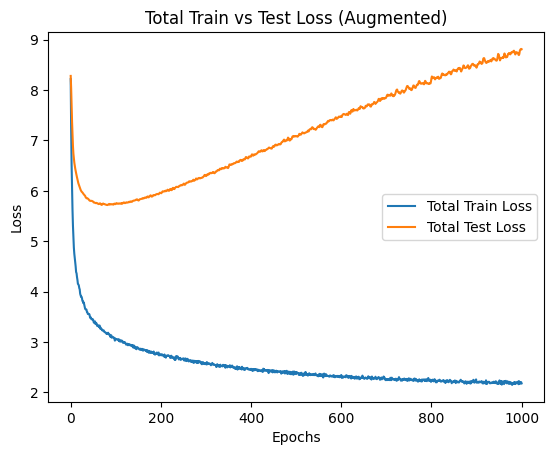

In [17]:
# plot train-test loss graph

plt.plot(range(len(train_total_loss_list)), train_total_loss_list, label="Total Train Loss")
plt.plot(range(len(test_total_loss_list)), test_total_loss_list, label="Total Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Total Train vs Test Loss (Augmented)")
plt.legend()
plt.show()